Notebook for producing skymap-related plots

In [1]:
import h5py
import datetime
import humanize
import numpy as np
import pathlib
from ligo.skymap import moc, io, postprocess
from astropy import units as u
sr_to_deg2 = u.sr.to(u.deg**2)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pycbc.cosmology
import json
from scipy import stats
import seaborn as sns
from astropy.table import Table
import seaborn as sns
import json
from plotting_utils import generate_all_params
from ligo.skymap.plot.marker import reticle
from astropy.coordinates import SkyCoord

from plotting_utils import (
    psd_colours,
    psd_markers,
    times_lookup,
    psd_labels,
    psd_ls,
    get_times_array,
    generate_all_params,
    get_priors,
)
psds = list(psd_colours.keys())

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("../Data/injections.json", "r") as f:
    injection_parameters = json.load(f)
injection_parameters = {k: generate_all_params(v) for k, v in injection_parameters.items()}

In [3]:
def compute_skymap_area(fits_file, levels):
    """Compute the area of the skymap

    Based on the code from ligo.skymap.
    """
    skymap = io.fits.read_sky_map(fits_file, moc=True)
    dA = moc.uniq2pixarea(skymap['UNIQ'])
    dP = skymap['PROBDENSITY'] * dA
    dP = skymap['PROBDENSITY'] * dA
    cls = 100 * postprocess.find_greedy_credible_levels(dP, skymap['PROBDENSITY'])
    i = np.flipud(np.argsort(skymap['PROBDENSITY']))
    area = np.interp(levels, cls[i], np.cumsum(dA[i]), left=0, right=4 * np.pi)
    return area * sr_to_deg2

In [4]:
figure_dir = pathlib.Path("figures")
figure_dir.mkdir(exist_ok=True)

In [5]:
skymap_path = pathlib.Path("Making_Skymaps")

Load the pre-computed fits file.

See the readme for instructions on how to produce the files.

In [6]:
fits_files = {}
for inj in range(0, 5):
    inj_key = f"injection {inj}"
    fits_files[inj_key] = {}
    for psd in psds:
        fits_files[inj_key][psd] = {}
        for time in range(1, 6):
            fits_file = skymap_path / f"injection_{inj}" / psd /f"sky_map_time_{time}.fits.gz"
            if fits_file.exists():
                fits_files[inj_key][psd][f"time {time}"] = str(fits_file)

In [7]:
posterior_samples = {}
for inj in range(5):
    posterior_samples[inj] = {}
    with h5py.File(f"Running_Analyses/results/injection_{inj}_merged.hdf", "r") as f:
        for key in f.keys():
            posterior_samples[inj][key] = {}

            for time, samples in f[key].items():
                posterior_samples[inj][key][time] = {}
                posterior_samples[inj][key][time]["comoving_volume"] = samples[()]["comoving_volume"]
    del samples

In [8]:
# Avoid values since we will modify in place
for inj in posterior_samples.keys():
    for psd in posterior_samples[inj].keys():
        for time in posterior_samples[inj][psd].keys():
            posterior_samples[inj][psd][time]["redshift"] = pycbc.cosmology.redshift_from_comoving_volume(posterior_samples[inj][psd][time]["comoving_volume"])

In [9]:
prior_parameters = ["comoving_volume"]
priors=   {}
for parameter in prior_parameters:
    priors[parameter] = {}
    for i in range(5):
        priors[parameter][i] = get_priors(f"Config_Files/injections/cut_psd/injection{i}.ini", parameter)[0]
priors["redshift"] = {k: pycbc.cosmology.redshift_from_comoving_volume(v) for k, v in priors["comoving_volume"].items()}

## Figure 10

Skipping time 5 for injection injection 0
Skipping time 5 for injection injection 0
Skipping time 5 for injection injection 0
Skipping time 5 for injection injection 1
Skipping time 5 for injection injection 1
Skipping time 5 for injection injection 1
Skipping time 5 for injection injection 2
Skipping time 5 for injection injection 2
Skipping time 5 for injection injection 2


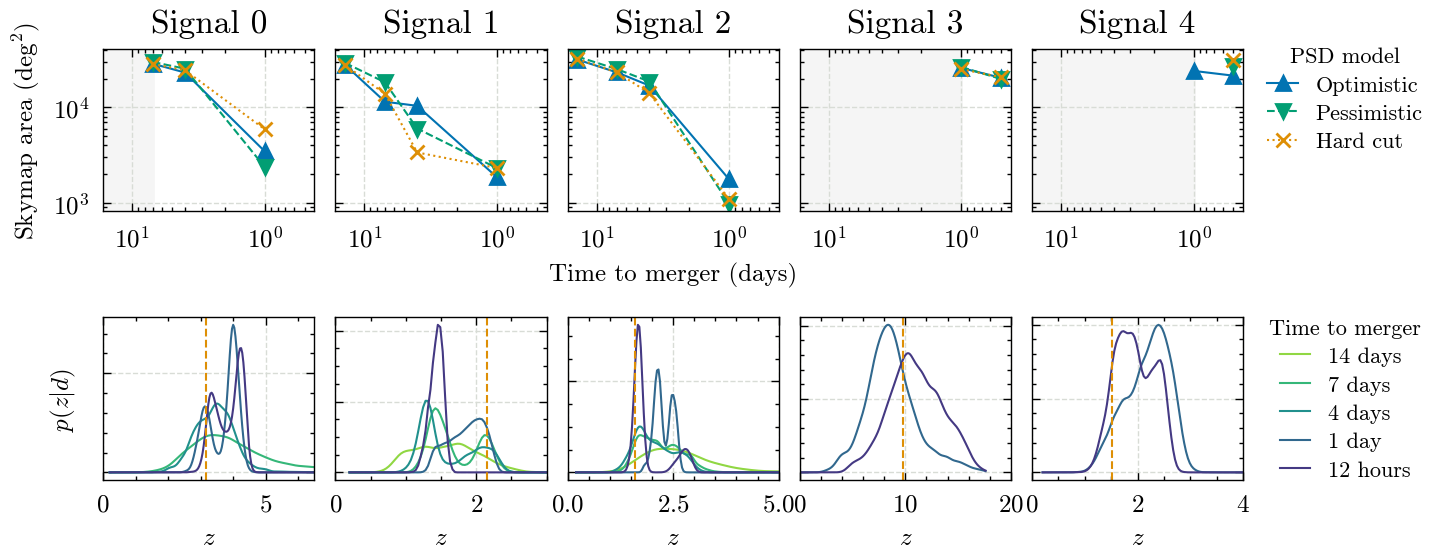

In [10]:
with plt.rc_context(fname="../paper.mplstyle"):
    figsize = plt.rcParams["figure.figsize"].copy()
    figsize[0] = 2 * figsize[0]
    figsize[1] = 1.5 * figsize[1]
    
    fig, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=figsize)
    
    for i in range(4):
        axs[0, i].sharex(axs[0, 4])
        axs[0, i].sharey(axs[0, 4])
    
    for inj, inj_ff in fits_files.items():
        ax_idx = int(inj.split(" ")[-1])
        for psd, psd_ff in inj_ff.items():
            areas = {}
            for time, ff in psd_ff.items():
                if time == "time 5" and int(inj[-1]) in [0, 1, 2]:
                    print(f"Skipping time 5 for injection {inj}")
                    continue
                areas[time] = compute_skymap_area(ff, [99.0])
                
            time_array = get_times_array(areas.keys())
            area_array = np.array(list(areas.values()))
            axs[0, ax_idx].plot(time_array, area_array, marker=psd_markers[psd], c=psd_colours[psd], ls=psd_ls[psd])
            # axs[0, int(inj.split(" ")[-1])].set_xlim(1, 0.1)
        # # Vera Rubin 
        # axs[0, ax_idx].axhline(9.6, ls="--")
    
    axs[0, 0].invert_xaxis()
    axs[0, 0].set_xscale("log")
    axs[0, 0].set_yscale("log")
    
    axs[0, 0].set_ylabel(r"Skymap area (deg$^2$)")
    axs[0, 2].set_xlabel("Time to merger (days)")
    
    for ax in [axs[0, 3], axs[0, 4]]:
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.fill_between([1, xlims[0]], *ylims, color="whitesmoke", zorder=0)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
    
    
    ax = axs[0, 0]
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.fill_between([7, xlims[0]], *ylims, color="whitesmoke", zorder=0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    legend_handles = [
        Line2D([0], [1], label=psd_labels[psd], ls=psd_ls[psd], marker=psd_markers[psd], c=psd_colours[psd])
        for psd in psds
    ]
    fig.legend(
        handles=legend_handles,
        title="PSD model",
        loc="center",
        bbox_to_anchor=(1.05, 0.8),
        ncol=1,
        # alignment="left",
    )
    
    parameter = "redshift"
    psd = "optimistic"
    x_ranges = [
        [0, 6.5],
        [0, 3],
        [0, 5],
        [0, 20],
        [0, 4],
    ]
    colours = sns.color_palette("viridis_r", n_colors=5)
    truth_color = "C1"
    truth_ls = "--"
    
    for inj, inj_samples in posterior_samples.items():
        truth = injection_parameters[str(inj)].get(parameter, None)
        psd_samples = inj_samples[psd]
        times = get_times_array(psd_samples.keys())
        for time, samples in psd_samples.items():
            kde = stats.gaussian_kde((samples[parameter]))
            xx = np.linspace(*priors[parameter][inj], 500)
            axs[1, inj].plot(xx, kde(xx), color=colours[int(time.split(" ")[-1]) - 1], label=humanize.precisedelta(datetime.timedelta(days=times_lookup[time])))
        axs[1, inj].axvline(truth, color=truth_color, ls=truth_ls)
        axs[1, inj].set_xlim(*x_ranges[inj])
        axs[1, inj].set_yticklabels([])
        axs[1, inj].set_xlabel(r"$z$")
    
    h, l = axs[1, 2].get_legend_handles_labels()
    
    fig.legend(
        h, l,
        title="Time to merger",
        loc="center",
        bbox_to_anchor=(1.05, 0.3),
        ncol=1,
    )
    
    axs[1, 0].set_ylabel(r"$p(z|d)$")
    
    # Add titles, grid
    # Remove tick labels from shared y-axis
    for i in range(5):
        axs[0, i].set_title(f"Signal {i}")
        axs[0, i].grid()
        axs[1, i].grid()
        if i > 0:
            axs[0, i].tick_params('y', labelleft=False)
    # axs[0, 0].set_yticklabels(yticklabels)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    plt.show()

## Figure 11

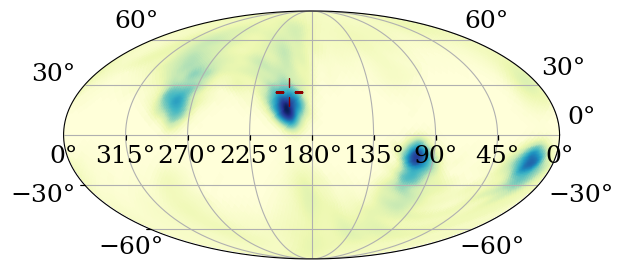

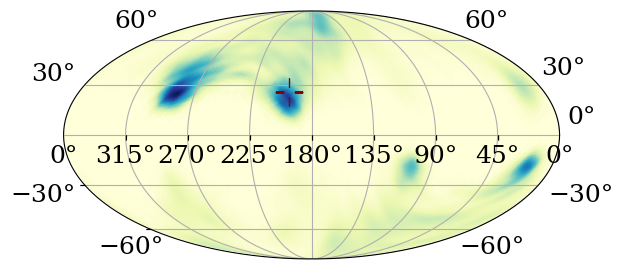

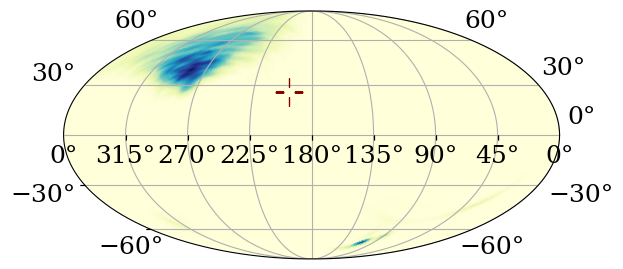

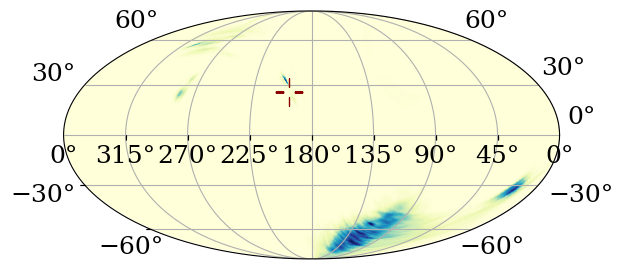

In [11]:
injection_id = 0
truth = injection_parameters[str(injection_id)]
psd = "cut"

truth_coord = SkyCoord(
    truth["eclipticlongitude"],
    truth["eclipticlatitude"],
    unit=u.rad,
    
)

with plt.rc_context(rc={
    "grid.linestyle": "-",
    "font.size": 18,
    "font.family": "serif",
    "mathtext.fontset": "dejavuserif"
}):
    for i, time in enumerate([2, 3, 4, 5]):
        fig = plt.figure()
        ax = plt.axes(projection="astro degrees mollweide")
        ax.grid()
        fits_file = skymap_path / f"injection_{injection_id}" / psd / f"sky_map_time_{time}.fits.gz"
        skymap = io.fits.read_sky_map(fits_file, moc=True)
        levels = [86, 99]
        dA = moc.uniq2pixarea(skymap['UNIQ'])
        dP = skymap['PROBDENSITY'] * dA
        cls = 100 * postprocess.find_greedy_credible_levels(dP, skymap['PROBDENSITY'])
        table = Table({'UNIQ': skymap['UNIQ'], 'CLS': cls})
      
        img = ax.imshow_hpx(
            (skymap, 'ICRS'),
            vmin=0,
            order='nearest-neighbor',
            cmap='YlGnBu',
        )
        
        ax.plot(
            truth_coord.ra.deg,
            truth_coord.dec.deg,
            marker=reticle(inner=3),
            markersize=20,
            color="darkred",
            transform=ax.get_transform("icrs")
        )
        plt.show()